In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
import os
from tqdm import tqdm

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

## dataset

In [2]:
ratebeer = pd.read_csv("../data/train_ratebeer_without_text.csv")

### 편의점 유통 맥주만 가져오기

In [3]:
kor_beer_list = np.array([ 8666,  75661, 614833, 169964,    251,  10726,   5588,   5571,
                        703,   6668,   7656,   2228, 135361,    473,  36249,    709,
                        12775, 143730,    742,   4007,  72025,  58275, 221535, 291276,
                        2469,   2468, 553454,   1088,    721,  30913,    814,  75071,
                        715,   1267,     55,  17334,     37, 493355,  64253,  34662,
                        136165, 500620,  13833, 506847,  73158,    399,   5159,   3101,
                        315443, 552713, 911382, 906973,    268, 550283, 271470,    390,
                        71469,  35424,   4701,   2514,   2516, 288954,    405, 303473,
                        136785,    647, 632627,   3029,    717, 553245, 580686, 252000,
                        21936, 667837,   2811,    729,  71458, 634182,  86387,   1478,
                        146878, 146725, 149060,  15747, 718172,   3126, 480225, 268685,
                        730, 211962,  64518, 621308,   7580, 452525,   1417,   1486,
                        221])

kor_ratebeer = ratebeer[ratebeer['beer_id'].isin(kor_beer_list)]

In [4]:
# 전체 데이터에서 한국 편의점 맥주 개수
len(kor_ratebeer['beer_name'].unique())

84

### 맥주 점수 분포 체크

In [5]:
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931605 entries, 0 to 2931604
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   review_score  float64
 1   review_time   object 
 2   appearance    float64
 3   aroma         float64
 4   palate        float64
 5   taste         float64
 6   overall       float64
 7   profile_name  object 
 8   beer_name     object 
 9   beer_id       int64  
 10  brewer_id     int64  
 11  abv           float64
 12  style         object 
 13  image_url     object 
 14  user_id       int64  
dtypes: float64(7), int64(3), object(5)
memory usage: 335.5+ MB


In [6]:
ratebeer['review_score'].unique()

array([3.9, 4.1, 3.8, 4. , 4.2, 3.7, 4.5, 4.8, 3.6, 4.7, 4.3, 4.9, 3.4,
       4.4, 5. , 3.5, 4.6, 3.3, 3. , 3.2, 2.9, 3.1, 2.5, 2.4, 2.7, 2.6,
       2.3, 2.8, 1.8, 1.9, 1.5, 1.6, 2.2, 2.1, 2. , 1.4, 1.7, 1.3, 0.9,
       1. , 0.5, 1.2, 1.1, 0.8, 0.6, 0.7])

In [7]:
ratebeer['review_score'].describe()

count    2.931605e+06
mean     3.369230e+00
std      7.281425e-01
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      3.800000e+00
max      5.000000e+00
Name: review_score, dtype: float64

<AxesSubplot:>

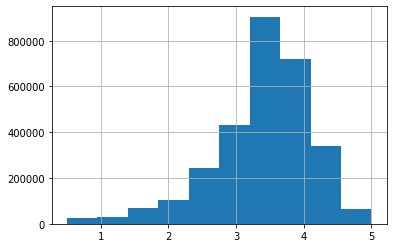

In [8]:
ratebeer['review_score'].hist()

<AxesSubplot:>

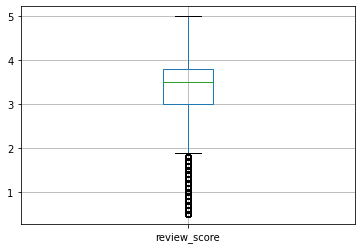

In [9]:
ratebeer[['review_score']].boxplot()

In [10]:
len(ratebeer)

2931605

### preprocessing

In [11]:
def preprocessing_df(df):
    # rating 전처리
    # df['rating/apperance'] = df['review/appearance'].str.split("/").str[0].astype(int)
    # df['rating/aroma'] = df['review/aroma'].str.split("/").str[0].astype(int)
    # df['rating/palate'] = df['review/palate'].str.split("/").str[0].astype(int)
    # df['rating/taste'] = df['review/taste'].str.split("/").str[0].astype(int)
    # df['rating/overall'] = df['review/overall'].str.split("/").str[0].astype(int)
    
    # overall rating 최대치 5로 변환
    # df['rating/overall'] = df['rating/overall'] / 20 * 5
    
    # item, user, rating만 추출
    df = df[['beer_id', 'profile_name', 'review_score', 'image_url']]
    df.rename(columns={'beer_id' : 'item', 'profile_name' : 'user', 'review_score' : 'rating'}, inplace = True) 
    
    # 유저 리뷰 수 개산
    df['user/reviewcount'] = df.groupby('user')['user'].transform('count')
    # 리뷰 수가 10개 이상인 유저만 남김 
    df = df[(df['user/reviewcount'] >= 10)]
    
#     df.drop(columns=['user/reviewcount'], inplace=True)
    
    num_users = df.user.unique().shape[0]
    num_items = df.item.unique().shape[0]
    return df, num_users, num_items

### Statistics of the Dataset

In [12]:
data, num_users, num_items = preprocessing_df(ratebeer)
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 13224, number of items: 9336
matrix sparsity: 0.977028
     item        user  rating  \
0  131594   jmgreenuk     3.9   
1  131594         Ron     3.9   
2  131594     olberic     4.1   
3  131594  bergstaden     4.1   
4  131594      rumore     3.8   

                                           image_url  user/reviewcount  
0  https://res.cloudinary.com/ratebeer/image/uplo...              1299  
1  https://res.cloudinary.com/ratebeer/image/uplo...              1667  
2  https://res.cloudinary.com/ratebeer/image/uplo...               110  
3  https://res.cloudinary.com/ratebeer/image/uplo...               652  
4  https://res.cloudinary.com/ratebeer/image/uplo...               386  


In [13]:
data['rating'].describe()

count    2.836096e+06
mean     3.361636e+00
std      7.133313e-01
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      3.800000e+00
max      5.000000e+00
Name: rating, dtype: float64

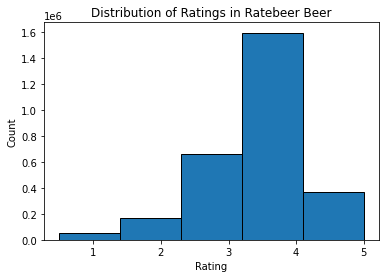

In [14]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Ratebeer Beer')
plt.show()

### Label Encoding

In [15]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user'].values)
data['item_id_idx'] = item_le.fit_transform(data['item'].values)

# data.drop(columns=['user', 'item_id'], inplace=True)

### Loading the data

In [16]:
class BeerDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode
        self.train_size = 0.9
        self.val_size = 0.1
        # self.test_size = 1 - self.train_size - self.val_size 

        self.num_items = len(self.df['item_id_idx'].unique())
        self.num_users = len(self.df['user_id_idx'].unique())
        
        n_val = int(self.num_users * self.val_size)
#         n_test = int(self.num_users * self.test_size)
        
        np.random.seed(42)
        
        val_indices = set(np.random.choice(range(self.num_users), n_val, replace = False))
        # test_indices = set(random.choices(list(set(range(self.num_users)) - val_indices), k=n_test))
        train_indices = set(range(self.num_users)) - val_indices # - test_indices
#         # self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_id_idx'].values, random_state=42)
        
        if self.mode == 'train':
            self.df = self.df[self.df['user_id_idx'].isin(train_indices)]
        elif self.mode == 'val':
            self.df = self.df[self.df['user_id_idx'].isin(val_indices)]
#         else:
#             self.df = self.df[self.df['user_id_idx'].isin(test_indices)]
        
        # 유저 리뷰 수 개산
        # self.df['user/reviewcount'] = self.df.groupby('user_id_idx')['user_id_idx'].transform('count')
        
        # #리뷰 수가 4개 이상인 유저만 남김 
        # self.df = self.df[(self.df['user/reviewcount'] > 3)]
        # self.df.drop(columns=['user/reviewcount'], inplace=True)
        
        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)
        
        self.inter_mat = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating
            
        # for user in self.users:
        #     nonzero_ind = np.where(inter_mat[user] > 0)[0]
        #     # if len(nonzero_ind) > 3:
        #     valid_ind = np.random.choice(nonzero_ind, 3, replace = False)
        #     if self.mode == 'train':
        #         inter_mat[user][valid_ind] = 0
        #     else:
        #         inter_mat[user][np.setdiff1d(nonzero_ind, valid_ind)] = 0

        return inter_mat

    def __len__(self):
        # return len(self.users)
        return len(self.inter_mat)

    def __getitem__(self, index):
        # inter_mat = torch.tensor(self.inter_mat[self.users[index]]).float()
        inter_mat = torch.tensor(self.inter_mat[index]).float()

        return index, inter_mat

### Autorec Model

In [17]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_items, dropout=0.2):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_items, num_hidden)
        self.activate = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_items)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.activate(self.encoder(mat)))
        pred = self.decoder(hidden)
        
        return pred

###  Model train, validcation

In [18]:
def train(model, train_iter, criterion, optm, device):
    model.train() # to train mode
    loss_sum = 0
    # loss_cal_count = 0

    for _, inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss = criterion(preds, inter_mat)

        # Update
        optm.zero_grad()      # reset gradient 
        loss.backward()      # backpropagate
        optm.step()      # optimizer update
        
        # if not np.isnan(loss.cpu().detach().numpy()):
        #     loss_cal_count += 1
        loss_sum += loss.item()
            
    loss_avg = loss_sum / len(train_iter)

    return loss_avg

In [19]:
def validation(model, valid_iter, criterion, device):
    
    # np.random.seed(42)
    
    with torch.no_grad():
        model.eval()
        loss_sum = 0
        loss_cal_count = 0
        
        for _, inter_mat in valid_iter:
            inter_mat = inter_mat.to(device)
            
#             # matrix 값 중 0보다 큰 값만 추출
#             y_for_compute = inter_mat.squeeze().cpu().numpy()
#             index = np.where(y_for_compute > 0)[0]
            
#             # 0보다 큰 값 중 n_val개를 masking
#             n_val = min(int(len(index) * 0.1), 3)
#             valid_ind = np.random.choice(index, n_val, replace = False)
#             y_for_compute[valid_ind] = 0
            
#             # n_val개 masking 된 input 생성
#             masked_input = torch.tensor(y_for_compute).to(device).unsqueeze(0)
            
#             # 정답지는 input에서 masking 되지 않은 위치를 masking  
#             if len(index):
#                 # print(len(index))
#                 # print(valid_ind)
#                 # print(index)
#                 mat_masked_idx = np.array([i for i in index if i not in valid_ind]) 
#                 # print(mat_masked_idx)
#                 inter_mat = inter_mat.squeeze().cpu().numpy()
#                 inter_mat[mat_masked_idx] = 0
#                 inter_mat = torch.tensor(inter_mat).to(device).unsqueeze(0)
            
            # mask된 input으로 prediction 후 기존 정답 활용 loss값 계산
            preds = model(inter_mat)
            loss = criterion(preds, inter_mat)
            
            if not np.isnan(loss.cpu().numpy()):
                loss_cal_count += 1
                loss_sum += loss.item()
            # loss_sum += loss.item()
      
    loss_avg = loss_sum / loss_cal_count
    # loss_avg = loss_sum / len(valid_iter)

        
    return loss_avg

In [20]:
class AutoRec_loss_fn(nn.Module):

    def __init__(self, loss_fn):
        super(AutoRec_loss_fn, self).__init__()
        self.loss_fn = loss_fn
    
    def forward(self, pred, y):
        y_for_compute = y.clone().to('cpu')
        index = np.where(y_for_compute > 0) # FILL HERE : USE np.where & y_for_compute. WARNING: y를 사용 시, y의 device가 gpu일 경우 오류 발생 #
        loss = self.loss_fn(pred[index], y[index])
        return loss

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 256

PATH = '../model/autorec_exp_rmse.pt'
patience = 5

num_items = data.item_id_idx.nunique()
num_hidden = 500

In [22]:
train_dataset = BeerDataset(df=data, mode='train')
val_dataset = BeerDataset(df=data, mode='val')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

In [23]:
model = AutoRec(num_hidden, num_items).to(device)
loss = AutoRec_loss_fn(nn.MSELoss().to(device)).to(device)
optm = optim.Adam(model.parameters(),lr=lr)

In [24]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

  2%|▎               | 1/50 [00:11<09:11, 11.26s/it]

Validation loss decreased (inf --> 0.627956).  Saving model ...
epoch: 0, train Loss: 1.5073, test Loss: 0.6280


  4%|▋               | 2/50 [00:21<08:24, 10.50s/it]

Validation loss decreased (0.627956 --> 0.527901).  Saving model ...
epoch: 1, train Loss: 0.3139, test Loss: 0.5279


  6%|▉               | 3/50 [00:31<08:01, 10.25s/it]

Validation loss decreased (0.527901 --> 0.466025).  Saving model ...
epoch: 2, train Loss: 0.3030, test Loss: 0.4660


  8%|█▎              | 4/50 [00:41<07:49, 10.21s/it]

Validation loss decreased (0.466025 --> 0.437186).  Saving model ...
epoch: 3, train Loss: 0.2982, test Loss: 0.4372


 10%|█▌              | 5/50 [00:51<07:35, 10.12s/it]

Validation loss decreased (0.437186 --> 0.418838).  Saving model ...
epoch: 4, train Loss: 0.2911, test Loss: 0.4188


 12%|█▉              | 6/50 [01:01<07:22, 10.05s/it]

Validation loss decreased (0.418838 --> 0.405628).  Saving model ...
epoch: 5, train Loss: 0.2869, test Loss: 0.4056


 14%|██▏             | 7/50 [01:11<07:09,  9.99s/it]

Validation loss decreased (0.405628 --> 0.392272).  Saving model ...
epoch: 6, train Loss: 0.2839, test Loss: 0.3923


 16%|██▌             | 8/50 [01:21<07:05, 10.12s/it]

Validation loss decreased (0.392272 --> 0.388162).  Saving model ...
epoch: 7, train Loss: 0.2795, test Loss: 0.3882


 18%|██▉             | 9/50 [01:31<06:52, 10.06s/it]

Validation loss decreased (0.388162 --> 0.381192).  Saving model ...
epoch: 8, train Loss: 0.2728, test Loss: 0.3812


 20%|███            | 10/50 [01:41<06:41, 10.03s/it]

Validation loss decreased (0.381192 --> 0.380209).  Saving model ...
epoch: 9, train Loss: 0.2672, test Loss: 0.3802


 22%|███▎           | 11/50 [01:51<06:34, 10.12s/it]

Validation loss decreased (0.380209 --> 0.376521).  Saving model ...
epoch: 10, train Loss: 0.2609, test Loss: 0.3765


 24%|███▌           | 12/50 [02:01<06:23, 10.09s/it]

Validation loss decreased (0.376521 --> 0.370028).  Saving model ...
epoch: 11, train Loss: 0.2557, test Loss: 0.3700


 26%|███▉           | 13/50 [02:12<06:19, 10.26s/it]

EarlyStopping counter: 1 out of 5
epoch: 12, train Loss: 0.2516, test Loss: 0.3742


 28%|████▏          | 14/50 [02:22<06:06, 10.19s/it]

Validation loss decreased (0.370028 --> 0.366143).  Saving model ...
epoch: 13, train Loss: 0.2474, test Loss: 0.3661


 30%|████▌          | 15/50 [02:32<05:54, 10.14s/it]

Validation loss decreased (0.366143 --> 0.363922).  Saving model ...
epoch: 14, train Loss: 0.2416, test Loss: 0.3639


 32%|████▊          | 16/50 [02:42<05:43, 10.10s/it]

Validation loss decreased (0.363922 --> 0.361933).  Saving model ...
epoch: 15, train Loss: 0.2378, test Loss: 0.3619


 34%|█████          | 17/50 [02:52<05:31, 10.05s/it]

EarlyStopping counter: 1 out of 5
epoch: 16, train Loss: 0.2320, test Loss: 0.3631


 36%|█████▍         | 18/50 [03:02<05:22, 10.09s/it]

Validation loss decreased (0.361933 --> 0.361376).  Saving model ...
epoch: 17, train Loss: 0.2284, test Loss: 0.3614


 38%|█████▋         | 19/50 [03:13<05:17, 10.26s/it]

EarlyStopping counter: 1 out of 5
epoch: 18, train Loss: 0.2238, test Loss: 0.3615


 40%|██████         | 20/50 [03:23<05:11, 10.40s/it]

Validation loss decreased (0.361376 --> 0.359192).  Saving model ...
epoch: 19, train Loss: 0.2197, test Loss: 0.3592


 42%|██████▎        | 21/50 [03:34<05:04, 10.51s/it]

Validation loss decreased (0.359192 --> 0.358091).  Saving model ...
epoch: 20, train Loss: 0.2172, test Loss: 0.3581


 44%|██████▌        | 22/50 [03:45<04:56, 10.60s/it]

Validation loss decreased (0.358091 --> 0.356308).  Saving model ...
epoch: 21, train Loss: 0.2122, test Loss: 0.3563


 46%|██████▉        | 23/50 [03:56<04:46, 10.63s/it]

Validation loss decreased (0.356308 --> 0.354542).  Saving model ...
epoch: 22, train Loss: 0.2086, test Loss: 0.3545


 48%|███████▏       | 24/50 [04:07<04:40, 10.79s/it]

Validation loss decreased (0.354542 --> 0.353992).  Saving model ...
epoch: 23, train Loss: 0.2060, test Loss: 0.3540


 50%|███████▌       | 25/50 [04:18<04:29, 10.80s/it]

Validation loss decreased (0.353992 --> 0.352943).  Saving model ...
epoch: 24, train Loss: 0.2027, test Loss: 0.3529


 52%|███████▊       | 26/50 [04:28<04:19, 10.80s/it]

Validation loss decreased (0.352943 --> 0.351705).  Saving model ...
epoch: 25, train Loss: 0.1998, test Loss: 0.3517


 54%|████████       | 27/50 [04:39<04:07, 10.77s/it]

Validation loss decreased (0.351705 --> 0.350923).  Saving model ...
epoch: 26, train Loss: 0.1964, test Loss: 0.3509


 56%|████████▍      | 28/50 [04:50<03:56, 10.75s/it]

Validation loss decreased (0.350923 --> 0.349129).  Saving model ...
epoch: 27, train Loss: 0.1940, test Loss: 0.3491


 58%|████████▋      | 29/50 [05:00<03:44, 10.69s/it]

EarlyStopping counter: 1 out of 5
epoch: 28, train Loss: 0.1911, test Loss: 0.3494


 60%|█████████      | 30/50 [05:11<03:32, 10.64s/it]

EarlyStopping counter: 2 out of 5
epoch: 29, train Loss: 0.1880, test Loss: 0.3503


 62%|█████████▎     | 31/50 [05:22<03:22, 10.64s/it]

Validation loss decreased (0.349129 --> 0.347735).  Saving model ...
epoch: 30, train Loss: 0.1865, test Loss: 0.3477


 64%|█████████▌     | 32/50 [05:32<03:11, 10.65s/it]

Validation loss decreased (0.347735 --> 0.346206).  Saving model ...
epoch: 31, train Loss: 0.1809, test Loss: 0.3462


 66%|█████████▉     | 33/50 [05:43<02:59, 10.55s/it]

EarlyStopping counter: 1 out of 5
epoch: 32, train Loss: 0.1798, test Loss: 0.3462


 68%|██████████▏    | 34/50 [05:52<02:45, 10.36s/it]

EarlyStopping counter: 2 out of 5
epoch: 33, train Loss: 0.1780, test Loss: 0.3464


 70%|██████████▌    | 35/50 [06:03<02:34, 10.27s/it]

EarlyStopping counter: 3 out of 5
epoch: 34, train Loss: 0.1752, test Loss: 0.3475


 72%|██████████▊    | 36/50 [06:13<02:23, 10.26s/it]

Validation loss decreased (0.346206 --> 0.345219).  Saving model ...
epoch: 35, train Loss: 0.1745, test Loss: 0.3452


 74%|███████████    | 37/50 [06:23<02:12, 10.17s/it]

EarlyStopping counter: 1 out of 5
epoch: 36, train Loss: 0.1722, test Loss: 0.3474


 76%|███████████▍   | 38/50 [06:33<02:01, 10.13s/it]

EarlyStopping counter: 2 out of 5
epoch: 37, train Loss: 0.1708, test Loss: 0.3481


 78%|███████████▋   | 39/50 [06:43<01:51, 10.11s/it]

Validation loss decreased (0.345219 --> 0.343490).  Saving model ...
epoch: 38, train Loss: 0.1677, test Loss: 0.3435


 80%|████████████   | 40/50 [06:53<01:40, 10.04s/it]

EarlyStopping counter: 1 out of 5
epoch: 39, train Loss: 0.1665, test Loss: 0.3447


 82%|████████████▎  | 41/50 [07:03<01:30, 10.01s/it]

EarlyStopping counter: 2 out of 5
epoch: 40, train Loss: 0.1654, test Loss: 0.3464


 84%|████████████▌  | 42/50 [07:13<01:20, 10.03s/it]

EarlyStopping counter: 3 out of 5
epoch: 41, train Loss: 0.1614, test Loss: 0.3437


 86%|████████████▉  | 43/50 [07:23<01:10, 10.00s/it]

Validation loss decreased (0.343490 --> 0.340620).  Saving model ...
epoch: 42, train Loss: 0.1592, test Loss: 0.3406


 88%|█████████████▏ | 44/50 [07:32<00:59,  9.95s/it]

EarlyStopping counter: 1 out of 5
epoch: 43, train Loss: 0.1587, test Loss: 0.3414


 90%|█████████████▌ | 45/50 [07:42<00:49,  9.90s/it]

EarlyStopping counter: 2 out of 5
epoch: 44, train Loss: 0.1579, test Loss: 0.3427


 92%|█████████████▊ | 46/50 [07:52<00:39,  9.86s/it]

EarlyStopping counter: 3 out of 5
epoch: 45, train Loss: 0.1556, test Loss: 0.3450


 94%|██████████████ | 47/50 [08:02<00:29,  9.82s/it]

EarlyStopping counter: 4 out of 5
epoch: 46, train Loss: 0.1537, test Loss: 0.3408


 94%|██████████████ | 47/50 [08:11<00:31, 10.47s/it]

EarlyStopping counter: 5 out of 5
Early stopping


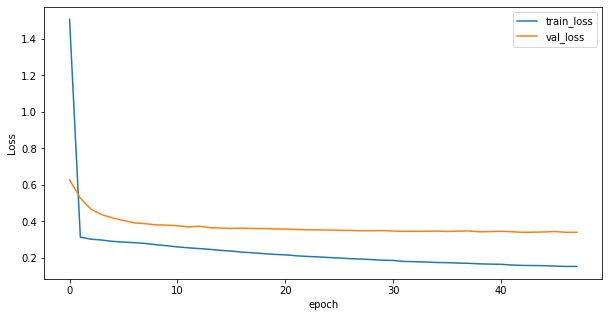

In [25]:
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience = patience, verbose = True, path=PATH)

for epoch in tqdm(range(num_epochs)):

    train_loss = train(model, train_dataloader, loss, optm, device)
    val_loss = validation(model, val_dataloader, loss, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {val_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(val_losses,label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## inference

### 모델 불러오기

In [26]:
model = AutoRec(num_hidden, num_items).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 파일 불러오기

In [27]:
test_input = pd.read_csv("../data/test_input_ratebeer_without_text.csv")
test_ans = pd.read_csv("../data/test_output_ratebeer_without_text.csv")

In [28]:
test_input.head()

,user_id,beer_id,review_score,review_time,appearance,aroma,palate,taste,overall,profile_name,beer_name,brewer_id,abv,style,image_url
0,4,12027,3.8,2021-08-23 02:21:37.730000+00:00,4.0,8.0,4.0,7.0,15.0,ZayZay,Boon Oude Geuze Mariage Parfait,748,8.0,Lambic - Gueuze,https://res.cloudinary.com/ratebeer/image/uplo...
1,4,59197,3.8,2020-10-24 01:01:04.880000+00:00,4.0,8.0,4.0,8.0,14.0,ZayZay,Le Trou du Diable La Buteuse,6444,10.0,Tripel,https://res.cloudinary.com/ratebeer/image/uplo...
2,4,59877,3.5,2021-04-10 00:07:47.060000+00:00,3.0,8.0,3.0,7.0,14.0,ZayZay,Dieu du Ciel! Rosée d'Hibiscus,364,5.9,Flavored - Other,https://res.cloudinary.com/ratebeer/image/uplo...
3,4,11461,4.1,2020-11-01 16:15:56.533000+00:00,3.0,9.0,3.0,9.0,17.0,ZayZay,Dieu du Ciel! Péché Mortel,364,9.5,Stout - Imperial Flavored / Pastry,https://res.cloudinary.com/ratebeer/image/uplo...
4,4,715,2.3,2021-07-08 02:36:24.657000+00:00,2.0,5.0,2.0,5.0,9.0,ZayZay,Grolsch Premium Lager,114,5.0,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...


In [29]:
test_ans.head()

,user_id,beer_id,review_score,review_time,appearance,aroma,palate,taste,overall,profile_name,beer_name,brewer_id,abv,style,image_url
0,4,37,1.9,2021-07-08 03:31:02.923000+00:00,3.0,3.0,2.0,3.0,8.0,ZayZay,Heineken,9,5.0,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
1,4,473,1.7,2022-05-27 03:50:49.850000+00:00,3.0,3.0,2.0,3.0,6.0,ZayZay,Budweiser,84,5.0,Pale Lager - American,https://res.cloudinary.com/ratebeer/image/uplo...
2,4,742,1.7,2020-10-24 21:25:51.827000+00:00,2.0,3.0,2.0,3.0,7.0,ZayZay,Corona Extra,119,4.5,Pale Lager - American,https://res.cloudinary.com/ratebeer/image/uplo...
3,6,1478,2.0,2010-12-29 10:07:17.433000+00:00,1.0,4.0,2.0,5.0,8.0,PapaSkeetSkeet,Stella Artois,260,5.2,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
4,6,717,3.3,2010-04-20 16:48:45.717000+00:00,4.0,7.0,3.0,5.0,14.0,PapaSkeetSkeet,Pilsner Urquell,115,4.4,Pilsener - Bohemian / Czech,https://res.cloudinary.com/ratebeer/image/uplo...


### labelEncoding

In [30]:
user_test_le = LabelEncoder()

test_input['user_id_idx'] = user_test_le.fit_transform(test_input['profile_name'].values)
test_input['item_id_idx'] = item_le.transform(test_input['beer_id'].values)

test_ans['user_id_idx'] = user_test_le.transform(test_ans['profile_name'].values)
test_ans['item_id_idx'] = item_le.transform(test_ans['beer_id'].values)


In [31]:
class TestBeerDataset(Dataset):
    def __init__(self, input_df, ans_df):
        self.input_df = input_df
        self.ans_df = ans_df

        self.num_items = self.input_df.item_id_idx.max() + 1
        self.num_users = self.input_df.user_id_idx.nunique()
        
        # input matrix
        self.users = torch.tensor(self.input_df['user_id_idx'].values)
        self.items = torch.tensor(self.input_df['item_id_idx'].values)
        self.ratings = torch.tensor(self.input_df['review_score'].values)
        
        self.inter_mat_input = self.make_inter_mat()
        
        # ans matrix
        self.users = torch.tensor(self.ans_df['user_id_idx'].values)
        self.items = torch.tensor(self.ans_df['item_id_idx'].values)
        self.ratings = torch.tensor(self.ans_df['review_score'].values)
        
        self.inter_mat_ans = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating

        return inter_mat

    def __len__(self):
        # return len(self.users)
        return len(self.inter_mat_input)

    def __getitem__(self, index):
        # inter_mat = torch.tensor(self.inter_mat[self.users[index]]).float()
        inter_mat_input = torch.tensor(self.inter_mat_input[index]).float()
        inter_mat_ans = torch.tensor(self.inter_mat_ans[index]).float()

        return index, inter_mat_input, inter_mat_ans

### 평가지표 함수

In [32]:
def ndcg_k(actual, predicted, topk):
    res = 0
    for user_id in range(len(actual)):
        k = min(topk, len(actual[user_id]))
        idcg = idcg_k(k)
        dcg_k = sum(
            [
                int(predicted[user_id][j] in set(actual[user_id])) / math.log(j + 2, 2)
                for j in range(topk)
            ]
        )
        res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k(actual, predicted, topk):
    sum_recall = 0.0
    num_users = len(predicted)
    true_users = 0
    for i in range(num_users):
        act_set = set(actual[i])
        pred_set = set(predicted[i][:topk])
        if len(act_set) != 0:
            sum_recall += len(act_set & pred_set) / float(len(act_set))
            true_users += 1
    return sum_recall / true_users

In [32]:
def inference(model, test_iter, criterion, device):
    
    # np.random.seed(42)
    
    with torch.no_grad():
        model.eval()
        loss_sum = 0
        loss_cal_count = 0
        
        for _, inter_mat_input, inter_mat_ans in test_iter:
            inter_mat_input = inter_mat_input.to(device)
            inter_mat_ans = inter_mat_ans.to(device)
            
#             # matrix 값 중 0보다 큰 값만 추출
#             y_for_compute = inter_mat.squeeze().cpu().numpy()
#             index = np.where(y_for_compute > 0)[0]
            
#             # 0보다 큰 값 중 n_val개를 masking
#             n_val = min(int(len(index) * 0.1), 3)
#             valid_ind = np.random.choice(index, n_val, replace = False)
#             y_for_compute[valid_ind] = 0
            
#             # n_val개 masking 된 input 생성
#             masked_input = torch.tensor(y_for_compute).to(device).unsqueeze(0)
            
#             # 정답지는 input에서 masking 되지 않은 위치를 masking  
#             if len(index):
#                 # print(len(index))
#                 # print(valid_ind)
#                 # print(index)
#                 mat_masked_idx = np.array([i for i in index if i not in valid_ind]) 
#                 # print(mat_masked_idx)
#                 inter_mat = inter_mat.squeeze().cpu().numpy()
#                 inter_mat[mat_masked_idx] = 0
#                 inter_mat = torch.tensor(inter_mat).to(device).unsqueeze(0)
            
            # mask된 input으로 prediction 후 기존 정답 활용 loss값 계산
            preds = model(inter_mat_input)
            loss = criterion(preds, inter_mat_ans)
            
            if not np.isnan(loss.cpu().numpy()):
                loss_cal_count += 1
                loss_sum += loss.item()
            
        loss_avg = loss_sum / loss_cal_count
        print(f'test mse = {loss_avg}')
    return loss_avg

In [87]:
# def inference(model, test_iter, test_matrix, device, topk = 4):
#     pred_list = None
#     answer_list = None
#     with torch.no_grad():
#         model.eval()

#         for i, (user_ids, inter_mat) in enumerate(test_iter):
#             inter_mat = inter_mat.to(device)
            
#             rating_pred = model(inter_mat)
            
#             rating_pred = rating_pred.cpu().data.numpy().copy()
            
#             batch_user_index = user_ids.cpu().numpy()
#             answers = test_matrix.argsort(axis = 1)[batch_user_index, -topk:][:, ::-1]
#             # rating_pred[test_matrix[batch_user_index] > 0] = 0
            
#             ind = np.argpartition(rating_pred, -topk)[:, -topk:]
            
#             arr_ind = rating_pred[np.arange(len(rating_pred))[:, None], ind]

#             arr_ind_argsort = np.argsort(arr_ind)[np.arange(len(rating_pred)), ::-1]

#             batch_pred_list = ind[
#                 np.arange(len(rating_pred))[:, None], arr_ind_argsort
#             ]

#             if i == 0:
#                 pred_list = batch_pred_list
#                 answer_list = answers
#             else:
#                 pred_list = np.append(pred_list, batch_pred_list, axis=0)
#                 answer_list = np.append(
#                         answer_list, answers, axis=0
#                 )
            
#         recall = recall_at_k(answer_list, pred_list, topk)
#         ndcg = ndcg_k(answer_list, pred_list, topk)
        
#         print(f'recall@{topk} = {recall}, ndcg@{topk} = {ndcg}')
#     return pred_list, answer_list

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 1

num_items = data.item_id_idx.nunique()
num_hidden = 500

In [34]:
test_dataset = TestBeerDataset(input_df = test_input, ans_df = test_ans)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# test_matrix = test_dataset.inter_mat
loss = AutoRec_loss_fn(nn.MSELoss().to(device)).to(device)

### inference 수행

In [35]:
# pred_list, answer_list = inference(model, test_dataloader, test_matrix, device, topk=4)
# model, test_iter, criterion, device
mse = inference(model, test_dataloader, loss, device)

test mse = 0.7245696075029318


### 웹사이트 inference

In [36]:
kor_beer_list = np.array([ 8666,  75661, 614833, 169964,    251,  10726,   5588,   5571,
                        703,   6668,   7656,   2228, 135361,    473,  36249,    709,
                        12775, 143730,    742,   4007,  72025,  58275, 221535, 291276,
                        2469,   2468, 553454,   1088,    721,  30913,    814,  75071,
                        715,   1267,     55,  17334,     37, 493355,  64253,  34662,
                        136165, 500620,  13833, 506847,  73158,    399,   5159,   3101,
                        315443, 552713, 911382, 906973,    268, 550283, 271470,    390,
                        71469,  35424,   4701,   2514,   2516, 288954,    405, 303473,
                        136785,    647, 632627,   3029,    717, 553245, 580686, 252000,
                        21936, 667837,   2811,    729,  71458, 634182,  86387,   1478,
                        146878, 146725, 149060,  15747, 718172,   3126, 480225, 268685,
                        730, 211962,  64518, 621308,   7580, 452525,   1417,   1486,
                        221])

kor_ratebeer = ratebeer[ratebeer['beer_id'].isin(kor_beer_list)]

In [37]:
kor_ratebeer['review_score'].describe()

count    89498.000000
mean         2.760370
std          0.944286
min          0.500000
25%          2.100000
50%          2.900000
75%          3.500000
max          5.000000
Name: review_score, dtype: float64

In [38]:
kor_beer_idx = data[data['item'].isin(kor_beer_list)]['item_id_idx'].unique()

In [52]:
# 웹사이트 input
# x_test = torch.tensor([1.9, 0. , 0. , 1.5, 2.2, 2.1, 3.5, 1.9, 1.4, 3.4, 2.8, 0. , 0. ,
#        3.3, 0. , 3.6, 1.7, 1.6, 3.5, 3.8, 2.8, 2.2, 0. , 2.9, 3. , 3. ,
#        3.4, 3.3, 0. , 0. , 2. , 2.4, 0. , 1.8, 0. , 2.3, 0. , 0. , 0. ,
#        0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.2, 0. , 0. , 0. , 0. , 3. ,
#        3.1, 0. , 1.9, 3.7, 2. , 0. , 3.8, 0. , 0. , 0. , 0. , 0. , 0. ,
#        0. , 0. , 0. , 0. , 0. , 3. , 1.8, 0. , 0. , 0. , 0. , 0. , 0. ,
#        0. , 0. , 0. ]).to(device)

num_item = data['item'].nunique()

# 한국 맥주 평가
rating_list = [5.0, 2.76, 0.5] # 좋아요, 몰라요, 싫어요
kor_beer_idx = data[data['item'].isin(kor_beer_list)]['item_id_idx'].unique()
show_list = np.random.choice(kor_beer_idx, 29, replace=False) # 임의로 29개 추출
not_show_list = set(kor_beer_idx) - set(show_list)
x_test = torch.zeros(num_item).to(device) # 0으로 초기화

for beer in show_list:
    x_test[beer] = random.choice(rating_list) # 29개에 대해서 임의로 평가
    
# for beer in not_show_list:
#     x_test[beer] = rating_list[1] # 나머지는 몰라요로 배정
    
# show_df = data[data['item_id_idx'].isin(show_list)]

# 나머지 맥주 중 일부 평가
not_kor_rating_list = [5.0, 3.36, 0.5]
not_kor_idx = np.delete(np.arange(num_item), kor_beer_idx)
not_kor_choice = np.random.randint(int(len(not_kor_idx) * 0.3))
not_kor_list = np.random.choice(not_kor_idx, not_kor_choice , replace=False) 

for beer in not_kor_list:
    x_test[beer] = random.choice(not_kor_rating_list)

# for i in not_show_list:
#     style = data[data['item_id_idx'] == i]['label'].unique()[0]
#     rating = show_df[show_df['label'] == style]['rating'].mean()
    
#     if np.isnan(rating):
#         rating = rating_list[1] # style로 점수를 채울 수 없는 경우 몰라요로 채운다
#     x_test[i] = rating
#     # print(rating)

# 추천 맥주 개수
topk = 4

# 모델 에측 맥주 평점
rating_pred = model(x_test)

rating_pred = rating_pred.cpu().data.numpy().copy()
# print(rating_pred)

rating_pred = rating_pred[kor_beer_idx]
x_test = x_test[kor_beer_idx]
# batch_user_index = user_ids.cpu().numpy()


answers = x_test.cpu().numpy().argsort()[-topk:][::-1]
# print(answers)

# user가 리뷰를 남긴 맥주 추천하고 싶지 않을 때 사용

# if novelty:
# 좋아요, 싫어요로 직접 평가한 맥주는 다시 추천하지 않도록 설정
rating_pred[x_test.cpu().numpy() == rating_list[0]] = 0
rating_pred[x_test.cpu().numpy() == rating_list[2]] = 0
# print(rating_pred)

# topk 맥주 index
ind = np.argpartition(rating_pred, -topk)[-topk:]
# print(ind)

# topk 맥주 index별 평점
arr_ind = rating_pred[ind]
# print(arr_ind)

# 평점 기준으로 내림차순으로 정렬
arr_ind_argsort = np.argsort(arr_ind)[::-1]
# print(arr_ind_argsort)

# rating 내림차순 모델 예측 topk 맥주 index 
topk_pred_list = ind[arr_ind_argsort]
print(topk_pred_list)

# rating 내림차순 모델 예측 맥주 평점 중 topk개
topk_rating_list = rating_pred[topk_pred_list] #rating_pred[np.arange(len(rating_pred))[:, None], ind]
print(topk_rating_list)

[18  6  9 19]
[3.416766  3.2703178 3.2682452 3.2589982]


In [53]:
# 모델 예측 선호 맥주 top4
topk_pred_list

array([18,  6,  9, 19])

In [54]:
# 유저 실제 선호 맥주 top4
answers

array([27, 49, 56, 76])

In [55]:
rating_pred[topk_pred_list]

array([3.416766 , 3.2703178, 3.2682452, 3.2589982], dtype=float32)

In [56]:
label_list = ['good', 'unknown', 'bad']

for i, rating in enumerate(rating_list):
    print(label_list[i])
    print(list(sorted([rating_pred[i] for i in np.where(x_test.cpu().numpy() == rating)[0]], reverse=True)))
    print()

good
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

unknown
[3.416766, 3.2703178, 3.2589982, 3.1011105, 2.7217038, 2.5470698, 2.3598585, 2.3385963, 2.2435734, 2.0498514, 2.0451856, 1.9319882, 1.5421729]

bad
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



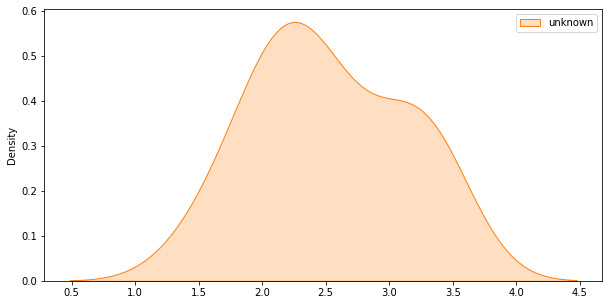

In [57]:
label_list = ['good', 'unknown', 'bad']

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, rating in enumerate(rating_list):
    
    ax = sns.kdeplot(sorted([rating_pred[i] for i in np.where(x_test.cpu().numpy() == rating)[0]], reverse=True), label = label_list[i], fill = True)

plt.legend()
plt.show()

<AxesSubplot:ylabel='Count'>

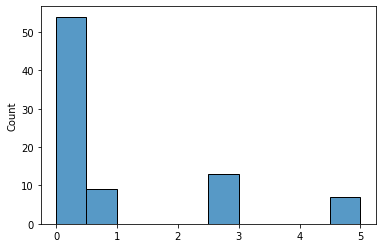

In [58]:
sns.histplot(x_test.cpu().numpy(), bins = 10)

<AxesSubplot:ylabel='Count'>

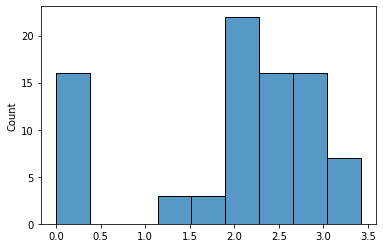

In [59]:
sns.histplot(rating_pred)

In [60]:
# 모델 예측 rating 점수
rating_pred

array([2.047485 , 2.9925442, 2.3088334, 2.0404248, 2.0498514, 3.0129635,
       3.2703178, 1.4554367, 1.3688322, 3.2682452, 2.4375732, 2.161606 ,
       2.4110057, 3.18344  , 2.4404755, 2.0451856, 2.1636817, 1.5421729,
       3.416766 , 3.2589982, 2.4445233, 2.528792 , 2.3598585, 0.       ,
       2.3385963, 0.       , 2.7511876, 0.       , 3.1011105, 0.       ,
       0.       , 2.5868766, 2.0925598, 2.1089776, 2.2382212, 0.       ,
       2.5923111, 0.       , 0.       , 2.2435734, 2.1556284, 2.10437  ,
       2.0912876, 2.961918 , 3.0323355, 2.7217038, 3.1058424, 1.7950395,
       2.5470698, 0.       , 2.5710516, 1.9768884, 3.0255919, 2.8011315,
       0.       , 2.4104464, 0.       , 2.6271226, 1.9694874, 0.       ,
       0.       , 2.165319 , 2.5583687, 0.       , 1.9619943, 2.0324445,
       2.774293 , 2.8785849, 1.9319882, 2.7717268, 1.805103 , 2.6670587,
       2.2569425, 2.2277644, 2.9973342, 1.3681163, 0.       , 2.8818018,
       2.704384 , 2.6635518, 2.1370914, 0.       , 

In [61]:
x_test

tensor([0.0000, 0.0000, 0.0000, 0.0000, 2.7600, 0.0000, 2.7600, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7600, 0.0000, 2.7600,
        2.7600, 2.7600, 0.0000, 0.0000, 2.7600, 5.0000, 2.7600, 5.0000, 0.0000,
        5.0000, 2.7600, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.5000, 0.5000, 2.7600, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        2.7600, 0.0000, 0.0000, 2.7600, 5.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000, 0.0000, 5.0000, 0.0000, 0.0000, 0.5000, 5.0000, 0.0000, 0.0000,
        0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7600, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 5.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5000, 0.0000], device='cuda:0')

In [62]:
kor_beer_idx

array([  23,   37,  132,  148,  159,  201,  205,  210,  258,  364,  405,
        410,  414,  415,  417,  419,  420,  432,  450,  553,  673, 6651,
        692,  695, 9329, 4851,  866,  981,  982, 1001, 1003, 4887, 1078,
       1128, 1144, 1147, 4925, 1339, 9039, 1503, 1612, 1697, 1705, 9073,
       6653, 9319, 6687, 9323, 1945, 2170, 6741, 2186,  612, 6814, 9334,
       6836, 2835, 9335, 6283, 9330, 9320, 9235, 3546, 9238, 3722, 9254,
       4665, 9326, 7342, 9328, 4051, 9322, 9321, 9332, 6012, 9327, 9324,
       9331, 9325, 9333, 6277, 3338, 2422])

In [63]:
# image url
data[data['item_id_idx'].isin(kor_beer_idx[topk_pred_list])]['image_url'].unique()

array(['https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_399',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_647',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_814',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_1088'],
      dtype=object)

In [64]:
# 맥주 이름
data[data['item_id_idx'].isin(kor_beer_idx[topk_pred_list])]['item'].unique()

array([ 399,  647,  814, 1088])

### 평가지표 점수

In [141]:
def ndcg_k_inf(actual, predicted, topk):
    res = 0
    k = min(topk, len(actual))
    idcg = idcg_k(k)
    dcg_k = sum(
        [
            int(predicted[j] in set(actual)) / math.log(j + 2, 2)
            for j in range(topk)
        ]
    )
    res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k_inf(actual, predicted, topk):
    act_set = set(actual)
    pred_set = set(predicted[:topk])
    if len(act_set) != 0:
        sum_recall = len(act_set & pred_set) / float(len(act_set))
        
    return sum_recall

In [142]:
recall_at_k_inf(answers, topk_pred_list, 4)

0.0

In [143]:
ndcg_k_inf(answers, topk_pred_list, 4)

0.0

In [144]:
data

,item,user,rating,imageUrl,user/reviewcount,user_id_idx,item_id_idx
0,75661,Grzesiek79,1.3,https://res.cloudinary.com/ratebeer/image/uplo...,55,3051,56
1,75661,GriZZZly,2.7,https://res.cloudinary.com/ratebeer/image/uplo...,13,3028,56
2,75661,bdleedahl,3.3,https://res.cloudinary.com/ratebeer/image/uplo...,31,8450,56
3,75661,DoctorHU,2.6,https://res.cloudinary.com/ratebeer/image/uplo...,48,2153,56
4,75661,McTapps,2.5,https://res.cloudinary.com/ratebeer/image/uplo...,49,4783,56
...,...,...,...,...,...,...,...
93615,703,Bov,3.0,https://res.cloudinary.com/ratebeer/image/uplo...,46,1215,10
93616,703,sallyclub99,4.2,https://res.cloudinary.com/ratebeer/image/uplo...,7,15196,10
93617,703,kublai3,2.7,https://res.cloudinary.com/ratebeer/image/uplo...,6,12689,10
93618,703,Aubrey,3.3,https://res.cloudinary.com/ratebeer/image/uplo...,23,520,10


In [40]:
data.to_csv('../data/ratebeer_label_encoding.csv', index = False)